# meta-VQE

Hot to obtain a Potential Energy Surface (PES) plot without training for *all* the points of interest.

## Keypoints

* For a molecule, the Hamiltonian depends on the geometry (separation) of the atoms or nuclei
* For simple, vanilla VQE, all the possible configurations (separations) in the molecule need to be trained separately
* meta-VQE trains a few points (training points), encoding the original parameters $\vec{\theta}$ using metaparamers and a linear or Gaussian encoding.

The code below uses Catalyst (from Xanadu) and JAX to optimize calculations

In [1]:

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from scipy.optimize import minimize

import json

print(f"Pennylane {qml.__version__}")

np.random.seed(32)

# Import custom optimizers

from custom_optimizers import gradient_descent,spsa_optimizer,adam

Pennylane 0.31.0


In [2]:
## Layers and wires for circuits

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

# Building the molecular hamiltonian for H2
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method="pyscf",
)
SHOTS = 4000 ## 1000, None. If none is used, the result is analytic

WIRES = qubits

USE_SINGLES = False
USE_DOUBLES = True

init_state = qml.qchem.hf_state(2, qubits)

## https://docs.pennylane.ai/projects/catalyst/en/latest/code/api/catalyst.grad.html - 

TRAINERS = {"gradient_descent": 
            {"fun":gradient_descent, "options":{ 'maxiter': 150, 'tol':1e-4, "verbose":True}},
            "spsa":{ "fun":spsa_optimizer, "options":{ 'maxiter': 150, 'tol':1e-4, "verbose":True}},
            "adam":{"fun":adam, "options":{ 'maxiter': 150, 'tol':1e-4, 'demon':False, "verbose":True}},
            "demon_adam":{"fun":adam, "options":{ 'maxiter': 150, 'tol':1e-4, 'demon':True, "verbose":True}}}

GRADIENT_METHOD= "ps" ## fd, ps

TRAINING_ENERGIES= {"gradient_descent":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },
                    "spsa":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },
                    "adam":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },
                    "demon_adam":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },

                   }

gradient_methods = {"fd":"finite-diff", "ps":"parameter-shift", "adj":"adjoint"}


# Encoder: 
# Linear -> 1
# Gaussian -> 2

ENCODER_MULTIPLIER_DICT = {1:2,
                      2:4}

ENCODER = 2

shared_dev = qml.device("lightning.qubit", wires=WIRES, shots=SHOTS)

train_points_indexes = [2,6,10,14,18]

test_points = np.arange(0.6,5,0.2)

train_points = np.array([test_points[i] for i in train_points_indexes])

test_hamiltonians = []


for d in test_points:
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, d]) 
    
    hamiltonian, _ = qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        method="pyscf",
    )    
    
    test_hamiltonians.append(hamiltonian)

train_hamiltonians = [test_hamiltonians[i] for i in train_points_indexes]
    
print("===== TRAIN POINTS =====")
print(train_points)

===== TRAIN POINTS =====
[1.  1.8 2.6 3.4 4.2]


In [3]:
singles, doubles = qml.qchem.excitations(2, WIRES, 0)

print(singles)
print(doubles)

[[0, 2], [1, 3]]
[[0, 1, 2, 3]]


In [4]:
with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)   

fci_energies = fci_h2["energies"]

### Linear Encoding

$\theta_{i} = w_{i} \, R + \phi_{i}$

In [5]:
def linear_encoding(param_array, r):
    """1-D array with alphas and betas. len(param_array) = 2 * len(weights) 

    Args:
        param_array (float): alphas and betas for lineasr encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """
    return param_array[::2]*r + param_array[1::2]

### Gaussian Encoding

$\theta_{i} = \alpha_{i} e^{\beta_{i} (\gamma_{i} - R)} + \delta_{i}$

In [6]:
def gaussian_encoding(param_array, r):
    """1-D array with alphas, betas, gammas and deltas. len(param_array) = 4 * len(weights) 

    Args:
        param_array (float): , betas, gammas and deltas for gaussian encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """

    exp_arg = param_array[1::4]*(param_array[2::4] - r)

    return param_array[::4]*np.exp(exp_arg) + param_array[3::4]

In [7]:
## Get shapes

## For linear is 2
## For Gaussian is 4
ENCODING_MULTIPLIER= ENCODER_MULTIPLIER_DICT[ENCODER]

if(ENCODER == 1):
    ENCODER_FUNC =linear_encoding
else:
    ENCODER_FUNC =gaussian_encoding

## Get shapes

num_params = 0

if(USE_SINGLES):
    for _ in singles:
        num_params+=1

if(USE_DOUBLES):
    for _ in doubles:
        num_params+=1     


num_params_encoding = num_params*ENCODING_MULTIPLIER

weights = np.random.random(num_params_encoding)

print("===== NUM OF PARAMETERS =====")
print(num_params_encoding)

===== NUM OF PARAMETERS =====
4


In [8]:
## Core circ

def core_circuit(params):

    qml.BasisState(init_state, wires=range(WIRES))    

    param_count = 0
    
    if(USE_SINGLES):
        for single_ex in singles: 
            qml.SingleExcitation(params[param_count], single_ex)
            param_count+=1

    if(USE_DOUBLES):
        for double_ex in doubles:
            qml.DoubleExcitation(params[param_count], double_ex)
            param_count+=1   
            

In [9]:
# Remember set h when using finite-diff - 1e-3
@qml.qnode(shared_dev, diff_method= gradient_methods[GRADIENT_METHOD], shots = SHOTS)
def normal_circuit(params, hamiltonian):

    core_circuit(params)

    return qml.expval(
        qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
    )  

@qml.qnode(shared_dev, diff_method= gradient_methods[GRADIENT_METHOD], shots = SHOTS)
def meta_circuit(params, hamiltonian, r):

    weights = ENCODER_FUNC(params,r)
    core_circuit(weights)

    return qml.expval(
        qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
    )  
if (GRADIENT_METHOD == 'fd'):
    normal_grad_fun = normal_circuit.gradient_fn(normal_circuit, h=1e-3, shots = SHOTS)
    meta_grad_fun = meta_circuit.gradient_fn(meta_circuit, shots = SHOTS)
else:
    normal_grad_fun = normal_circuit.gradient_fn(normal_circuit, h=1e-3, shots = SHOTS)
    meta_grad_fun = meta_circuit.gradient_fn(meta_circuit, shots = SHOTS)

In [10]:
specs_func = qml.specs(normal_circuit, expansion_strategy='gradient', max_expansion=50)
specs_func(gaussian_encoding(weights,1.4), test_hamiltonians[0])

/opt/conda/lib/python3.10/site-packages/pennylane/tape/qscript.py:1425: UserWarning: The gate_sizes key is deprecated and will be removed in the next release. Going forward, please use: specs["resources"].gate_sizes
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pennylane/tape/qscript.py:1425: UserWarning: The gate_types key is deprecated and will be removed in the next release. Going forward, please use: specs["resources"].gate_types
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pennylane/tape/qscript.py:1425: UserWarning: The num_operations key is deprecated and will be removed in the next release. Going forward, please use: specs["resources"].num_gates
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pennylane/tape/qscript.py:1425: UserWarning: The num_used_wires key is deprecated and will be removed in the next release. Going forward, please use: specs["resources"].num_wires
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pennylane/tape/qscript

{'resources': Resources(num_wires=4, num_gates=3, gate_types=defaultdict(<class 'int'>, {'PauliX': 2, 'DoubleExcitation': 1}), gate_sizes=defaultdict(<class 'int'>, {1: 2, 4: 1}), depth=2, shots=Shots(total_shots=None, shot_vector=())),
 'gate_sizes': defaultdict(int, {1: 2, 4: 1}),
 'gate_types': defaultdict(int, {'PauliX': 2, 'DoubleExcitation': 1}),
 'num_operations': 3,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 4,
 'num_trainable_params': 1,
 'depth': 2,
 'num_device_wires': 4,
 'device_name': 'lightning.qubit',
 'expansion_strategy': 'gradient',
 'gradient_options': {'shots': 4000},
 'interface': 'auto',
 'diff_method': 'parameter-shift',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 4}

In [11]:
specs_func = qml.specs(meta_circuit, expansion_strategy='gradient', max_expansion=50)
specs_func(weights, test_hamiltonians[0], 0.5)

{'resources': Resources(num_wires=4, num_gates=3, gate_types=defaultdict(<class 'int'>, {'PauliX': 2, 'DoubleExcitation': 1}), gate_sizes=defaultdict(<class 'int'>, {1: 2, 4: 1}), depth=2, shots=Shots(total_shots=None, shot_vector=())),
 'gate_sizes': defaultdict(int, {1: 2, 4: 1}),
 'gate_types': defaultdict(int, {'PauliX': 2, 'DoubleExcitation': 1}),
 'num_operations': 3,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 4,
 'num_trainable_params': 1,
 'depth': 2,
 'num_device_wires': 4,
 'device_name': 'lightning.qubit',
 'expansion_strategy': 'gradient',
 'gradient_options': {'shots': 4000},
 'interface': 'auto',
 'diff_method': 'parameter-shift',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 4}

In [12]:
print(normal_grad_fun(gaussian_encoding(weights,1.4), test_hamiltonians[0]))
distance = train_points[0]
distance.requires_grad = False
qml.gradients.finite_diff(meta_circuit)(weights, test_hamiltonians[0],distance)

1.5759484253213958


array([-217834.17688596,   83233.37550088,  -69732.55625721,
       -257119.91819342])

### Cost Function

Sum of energies for each configuration (separation)

$C(\vec{\theta}) = \sum_{i=1}^{M} \bra{\psi_{i}} \hat{H}(\vec{\lambda}_{i}) \ket{\psi_{i}}$


In [13]:
def meta_cost(params,train_hamiltonians, return_grad = True):

    energies = []  
    gradients = []
    


    for count, train_ham in enumerate(train_hamiltonians):
        
   
        energies.append(meta_circuit(params, train_ham, train_points[count]))
        if(return_grad):
            distance = train_points[count]
            distance.requires_grad = False
            gradients.append(meta_grad_fun(params, train_ham, distance))
        
    join_energy = np.sum(np.array(energies))
    
    if(return_grad):
        all_gradients = np.array(gradients)
        joined_gradients = np.sum(np.array([all_gradients[i][0] for i in range(len(all_gradients))]), axis=0)    
        
        return join_energy/len(train_points) , joined_gradients/len(train_points)
    else:
        return join_energy/len(train_points)

In [14]:
def normal_cost(params, hamiltonian, return_grad = True):
    
    if(return_grad):        
        return normal_circuit(params, hamiltonian), np.array(normal_grad_fun(params, hamiltonian))
    else:
        return normal_circuit(params, hamiltonian)

In [15]:
for train_method in TRAINERS:

    params_run = np.random.random(num_params_encoding)

    options = TRAINERS[train_method]["options"]
    options.update({"hamiltonian":train_hamiltonians})

    res_train = minimize(meta_cost, params_run, method = TRAINERS[train_method]["fun"], options = options)

    TRAINING_ENERGIES[train_method]["meta"]["trained_vars"] = res_train.x
    TRAINING_ENERGIES[train_method]["meta"]["energies"].append(res_train.fun)
    TRAINING_ENERGIES[train_method]["meta"]["runs"] = res_train.nit

Gradient Descent - Step:  0  Cost:  -0.8532813702847472
Gradient Descent - Step:  10  Cost:  -0.8932449245673872
Gradient Descent - Step:  20  Cost:  -0.9297143667822514
Gradient Descent - Step:  30  Cost:  -0.9521076452370865
Gradient Descent - Step:  40  Cost:  -0.9678190251568861
Gradient Descent - Step:  50  Cost:  -0.9740919579599019
Finished Gradient Descent training
SPSA - Step:  0  Cost:  -0.9583040038588659
SPSA - Step:  10  Cost:  -0.9611396777812538
SPSA - Step:  20  Cost:  -0.9637493140665949
SPSA - Step:  30  Cost:  -0.9612891127143296
SPSA - Step:  40  Cost:  -0.9628561856092986
Finished SPSA training
ADAM - Step:  0  Cost:  -0.9694146343501711
ADAM - Step:  10  Cost:  -0.985316884196952
Finished ADAM training
ADAM - Step:  0  Cost:  -0.9555622256640692
Finished ADAM training


<function matplotlib.pyplot.show(close=None, block=None)>

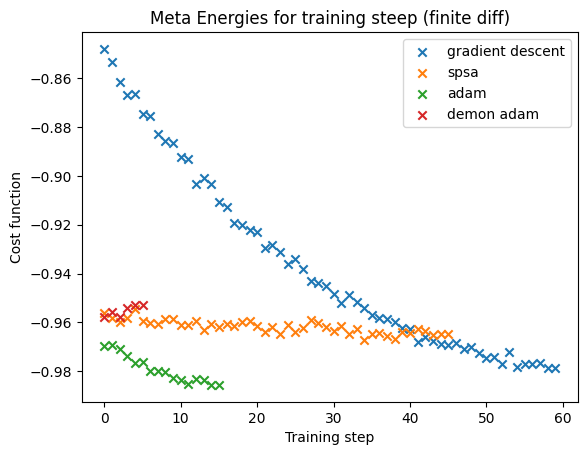

In [16]:
plt.scatter([i for i in range(len(TRAINING_ENERGIES['gradient_descent']["meta"]['energies'][-1]))],TRAINING_ENERGIES['gradient_descent']["meta"]['energies'][-1], label="gradient descent", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['spsa']["meta"]['energies'][-1]))],TRAINING_ENERGIES['spsa']["meta"]['energies'][-1], label="spsa", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['adam']["meta"]['energies'][-1]))],TRAINING_ENERGIES['adam']["meta"]['energies'][-1], label="adam", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['demon_adam']["meta"]['energies'][-1]))],TRAINING_ENERGIES['demon_adam']["meta"]['energies'][-1], label="demon adam", marker='x')

plt.legend()
plt.title('Meta Energies for training steep (finite diff)')
plt.ylabel('Cost function')
plt.xlabel('Training step')
plt.show

In [17]:
for count, d in enumerate(test_points):
    for train_method in TRAINERS:
        encoded_params = ENCODER_FUNC(TRAINING_ENERGIES[train_method]["meta"]["trained_vars"], d)
        TRAINING_ENERGIES[train_method]["meta"]["energies_after_meta"].append(normal_cost(encoded_params,test_hamiltonians[count], return_grad = False))

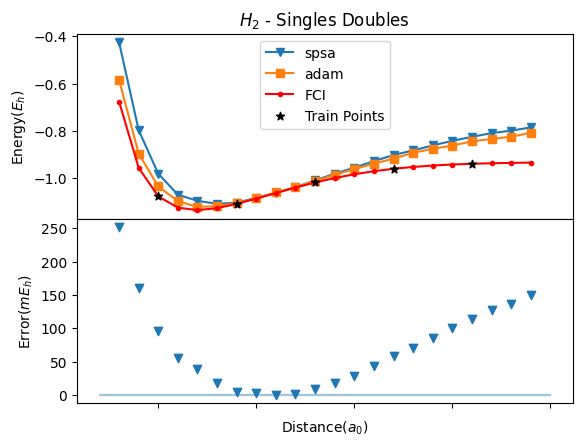

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

plt.subplots_adjust(hspace=0)

# ax1.plot(test_points, grad_descent_energies, label="gradient_descent", marker='s' , color=colors[0])
# ax1.plot(test_points, spsa_energies, label="spsa", marker='o', color=colors[1])
ax1.plot(test_points, TRAINING_ENERGIES["spsa"]["meta"]["energies_after_meta"], label="spsa", marker='v',)
ax1.plot(test_points, TRAINING_ENERGIES["adam"]["meta"]["energies_after_meta"], label="adam", marker='s', )
ax1.plot(test_points, fci_energies, label="FCI", marker='.', color="r")
ax1.scatter(train_points, [fci_energies[i] for i in train_points_indexes], zorder=99, label="Train Points", marker='*', color="black")


ax1.legend()
ax1.set_title('$H_{2}$ - Singles Doubles')
ax1.set_ylabel('Energy($E_{h}$)')

# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(grad_descent_energies ,fci_energies)], label="gradient_descent", marker='s', color=colors[0])
# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(adam_energies ,fci_energies)], label="adam", marker='v', color=colors[2])
ax2.scatter(test_points, [np.abs(i-j)*1000 for i,j in zip(TRAINING_ENERGIES["spsa"]["meta"]["energies_after_meta"] ,fci_energies)], label="spsa", marker='v')
# ax2.scatter(test_points, [np.abs(i-j)*1000 for i,j in zip(TRAINING_ENERGIES["adam"]["meta"]["energies_after_meta"] ,fci_energies)], label="adam", marker='s')


ax1.sharex(ax2)
ax1.set_xticklabels([])
ax2.autoscale() ## call autoscale if needed
ax2.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

# ax2.set_title('Error for each point')
ax2.set_xlabel('Distance($a_{0}$)')
ax2.set_ylabel('Error($mE_{h}$)')


plt.show()

In [19]:
for count, work_hamiltonian in enumerate(test_hamiltonians):

    init_params_run = ENCODER_FUNC(np.array(TRAINING_ENERGIES[train_method]["meta"]["trained_vars"]), test_points[count])

    for train_method in TRAINERS:

        options = TRAINERS[train_method]["options"]
        options.update({"hamiltonian":work_hamiltonian})

        res_train = minimize(normal_cost, init_params_run, method = TRAINERS[train_method]["fun"], options = options)

        TRAINING_ENERGIES[train_method]["opt_meta"]["trained_vars"].append(res_train.x)  
        TRAINING_ENERGIES[train_method]["opt_meta"]["energies"].append(res_train.fun)
        TRAINING_ENERGIES[train_method]["opt_meta"]["runs_per_step"].append(res_train.nit) 

        if(count == 0):
            params_run = np.random.random(num_params)
        else:
            params_run = TRAINING_ENERGIES[train_method]["vqe"]["trained_vars"][-1]

        res_train_vqe = minimize(normal_cost, params_run, method = TRAINERS[train_method]["fun"], options = options)

        TRAINING_ENERGIES[train_method]["vqe"]["trained_vars"].append(res_train_vqe.x)  
        TRAINING_ENERGIES[train_method]["vqe"]["energies"].append(res_train_vqe.fun)
        TRAINING_ENERGIES[train_method]["vqe"]["runs_per_step"].append(res_train_vqe.nit)           

Gradient Descent - Step:  0  Cost:  -0.6093797041616279
Gradient Descent - Step:  10  Cost:  -0.674567679917559
Gradient Descent - Step:  20  Cost:  -0.6754126735126756
Gradient Descent - Step:  30  Cost:  -0.6786743158321288
Gradient Descent - Step:  40  Cost:  -0.6786181482902257
Gradient Descent - Step:  50  Cost:  -0.6772436723191749
Gradient Descent - Step:  60  Cost:  -0.676256244330491
Gradient Descent - Step:  70  Cost:  -0.6782648653457856
Gradient Descent - Step:  80  Cost:  -0.6768752940675115
Finished Gradient Descent training
Gradient Descent - Step:  0  Cost:  -0.6258241809873674
Gradient Descent - Step:  10  Cost:  -0.6757472121176488
Gradient Descent - Step:  20  Cost:  -0.6739053803407827
Gradient Descent - Step:  30  Cost:  -0.6753401613633536
Gradient Descent - Step:  40  Cost:  -0.6791459415384572
Gradient Descent - Step:  50  Cost:  -0.6796946642948883
Gradient Descent - Step:  60  Cost:  -0.6769036220771499
Gradient Descent - Step:  70  Cost:  -0.6771742309886467


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()

# Plot for errors
ax.scatter(test_points,[np.abs(i-j)*1000 for i,j in zip([energy[-1] for energy in TRAINING_ENERGIES["spsa"]["opt_meta"]["energies"]],fci_energies)], label="opt meta", marker='o')
ax.scatter(test_points,[np.abs(i-j)*1000 for i,j in zip([energy[-1] for energy in TRAINING_ENERGIES["spsa"]["vqe"]["energies"]],fci_energies)], label="vqe", marker='o')
ax.scatter(test_points,[np.abs(i-j)*1000 for i,j in zip(TRAINING_ENERGIES["spsa"]["meta"]["energies_after_meta"],fci_energies)], label="meta", marker='o')


ax.legend()
ax.set_title('Error')
ax.set_yscale('log',base=10) 
ax.set_ylabel('Energy error (m Hartrees)')
ax.set_xlabel('Atomic Distance($a_{0}$)')


ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xticks(np.arange(min(test_points), max(test_points)+0.2, 1))

In [ ]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray) or isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
with open(f'exp_runs/meta_single_doubles_{GRADIENT_METHOD}.json', 'w') as f:
    f.write(json.dumps({
        "results": TRAINING_ENERGIES,

    }
    , indent=4, cls=NumpyEncoder))   